<a href="https://colab.research.google.com/github/munimshahriar1/abnormal-ecg-classification/blob/main/classifier_tensorflow_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Import all the libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objs as go
import plotly.express as px
from scipy.signal import medfilt, butter, filtfilt
import pywt
from sklearn.model_selection import train_test_split
import scipy.signal
from keras.models import Sequential
from keras.layers import LSTM, Dense, Reshape
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score
import seaborn as sns
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**Display the Data**

In [2]:
df = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


**Plot Graphs of Normal and Abnormal ECG**

In [3]:
#plot graphs of normal and abnormal ECG to visualise the trends

abnormal = df[df.loc[:,140] ==0][:10]
# Last column = 1 ---> normal; 0 ----> abnormal
normal = df[df.loc[:,140] ==1][:10]
# Create the figure
fig = go.Figure()
#create a list to display only a single legend
leg  = [False] * abnormal.shape[0]
leg[0] = True

# Plot training and validation error
for i in range(abnormal.shape[0]):
    fig.add_trace(go.Scatter( x=np.arange(abnormal.shape[1]),y=abnormal.iloc[i,:],name='Abnormal ECG', mode='lines',  marker_color='rgba(255, 0, 0, 0.9)', showlegend= leg[i]))
for j in range(normal.shape[0]):
    fig.add_trace(go.Scatter( x=np.arange(normal.shape[1]),y=normal.iloc[j,:],name='Normal ECG',  mode='lines',  marker_color='rgba(0, 255, 0, 1)', showlegend= leg[j]))
fig.update_layout(xaxis_title="time", yaxis_title="Signal", title= {'text': 'Difference between different ECG', 'xanchor': 'center', 'yanchor': 'top', 'x':0.5} , bargap=0,)
fig.update_traces(opacity=0.5)
fig.show()

# Machine Learning

**Data Preprocessing**

**Split Data into Data & Labels**

In [4]:
ecg_data = df.iloc[:,:-1]
labels = df.iloc[:,-1]

**Normalize Data between -1 and 1**

In [5]:
scaler = MinMaxScaler(feature_range=(-1, 1))
ecg_data = scaler.fit_transform(ecg_data)

**Filtering Raw Signals**

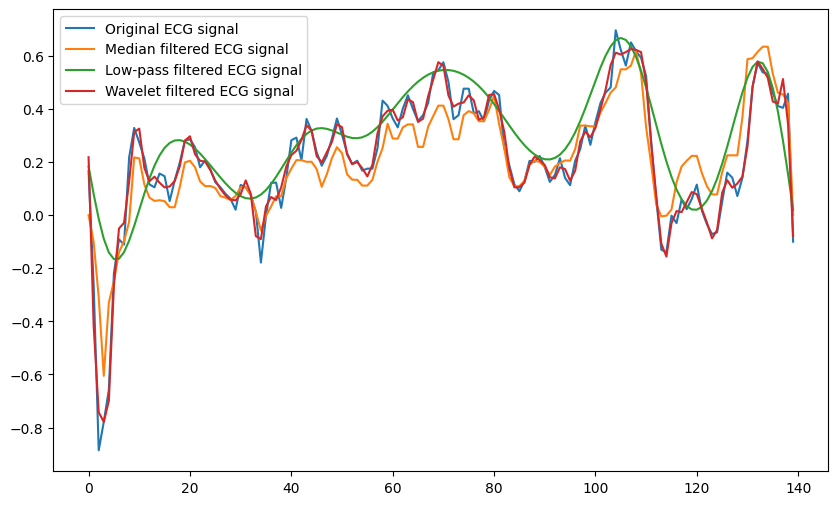

MSE value of Median Filtering: 0.017260298402611125
MSE value of Low-pass Filtering: 0.36750805414756493
MSE value of Wavelet Filtering: 0.0010818752598698714


In [6]:
# Median filtering
ecg_medfilt = medfilt(ecg_data, kernel_size=3)

# Low-pass filtering
lowcut = 0.05
highcut = 20.0
nyquist = 0.5 * 360.0
low = lowcut / nyquist
high = highcut / nyquist
b, a = butter(4, [low, high], btype='band')
ecg_lowpass = filtfilt(b, a, ecg_data)

# Wavelet filtering
coeffs = pywt.wavedec(ecg_data, 'db4', level=1)
threshold = np.std(coeffs[-1]) * np.sqrt(2*np.log(len(ecg_data)))
coeffs[1:] = (pywt.threshold(i, value=threshold, mode='soft') for i in coeffs[1:])
ecg_wavelet = pywt.waverec(coeffs, 'db4')

# Plotting all filtered signals

# Choose a specific ECG signal to plot
signal_number = 10

# Create a new figure
plt.figure(figsize=(10,6))

# Plot the original ECG signal
plt.plot(ecg_data[signal_number], label='Original ECG signal')

#Plot the median filtered ECG signal
plt.plot(ecg_medfilt[signal_number], label='Median filtered ECG signal')

# Plot the low-pass filtered ECG signal
plt.plot(ecg_lowpass[signal_number], label='Low-pass filtered ECG signal')

# Plot the wavelet filtered ECG signal
plt.plot(ecg_wavelet[signal_number], label='Wavelet filtered ECG signal')

# Add a legend
plt.legend()

# Display the plot
plt.show()

# Choosing the best filtering technique
# Pad the signal with zeroes
def pad_data(original_data,filtered_data):
  # Calculate the difference in length between the original data and filtered data
  diff = original_data.shape[1] - filtered_data.shape[1]
    # pad the shorter array with zeroes
  if diff > 0:
          # Create an array of zeros with the same shape as the original data
      padding = np.zeros((filtered_data.shape[0], original_data.shape[1]))
      # Concatenate the filtered data with the padding
      padded_data = np.concatenate((filtered_data, padding))
  elif diff < 0:
      padded_data = filtered_data[:,:-abs(diff)]
  elif diff == 0:
      padded_data = filtered_data
  return padded_data

# Computer the Mean  Squared Error
def mse(original_data, filtered_data):
    filter_data = pad_data(original_data,filtered_data)
    return np.mean((original_data - filter_data) ** 2)
# Calculate MSE
mse_value_m = mse(ecg_data, ecg_medfilt)
mse_value_l = mse(ecg_data, ecg_lowpass)
mse_value_w = mse(ecg_data, ecg_wavelet)

print("MSE value of Median Filtering:", mse_value_m)
print("MSE value of Low-pass Filtering:", mse_value_l)
print("MSE value of Wavelet Filtering:", mse_value_w)

**Splitting Data, Feature Extraction**

In [7]:
# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(ecg_wavelet, labels, test_size=0.2, random_state=42)

In [8]:
# Feature Extraction from training dataset
# Initializing an empty list to store the features
features = []
# Extracting features for each sample
for i in range(X_train.shape[0]):
    #Finding the R-peaks
    r_peaks = scipy.signal.find_peaks(X_train[i])[0]
    #Initialize lists to hold R-peak and T-peak amplitudes
    r_amplitudes = []
    t_amplitudes = []
    # Iterate through R-peak locations to find corresponding T-peak amplitudes
    for r_peak in r_peaks:
        # Find the index of the T-peak (minimum value) in the interval from R-peak to R-peak + 200 samples
        t_peak = np.argmin(X_train[i][r_peak:r_peak+200]) + r_peak
        #Append the R-peak amplitude and T-peak amplitude to the lists
        r_amplitudes.append(X_train[i][r_peak])
        t_amplitudes.append(X_train[i][t_peak])
    # extracting singular value metrics from the r_amplitudes
    std_r_amp = np.std(r_amplitudes)
    mean_r_amp = np.mean(r_amplitudes)
    median_r_amp = np.median(r_amplitudes)
    sum_r_amp = np.sum(r_amplitudes)
    # extracting singular value metrics from the t_amplitudes
    std_t_amp = np.std(t_amplitudes)
    mean_t_amp = np.mean(t_amplitudes)
    median_t_amp = np.median(t_amplitudes)
    sum_t_amp = np.sum(t_amplitudes)
    # Find the time between consecutive R-peaks
    rr_intervals = np.diff(r_peaks)
    # Calculate the time duration of the data collection
    time_duration = (len(X_train[i]) - 1) / 1000 # assuming data is in ms
    # Calculate the sampling rate
    sampling_rate = len(X_train[i]) / time_duration
    # Calculate heart rate
    duration = len(X_train[i]) / sampling_rate
    heart_rate = (len(r_peaks) / duration) * 60
    # QRS duration
    qrs_duration = []
    for j in range(len(r_peaks)):
        qrs_duration.append(r_peaks[j]-r_peaks[j-1])
    # extracting singular value metrics from the qrs_durations
    std_qrs = np.std(qrs_duration)
    mean_qrs = np.mean(qrs_duration)
    median_qrs = np.median(qrs_duration)
    sum_qrs = np.sum(qrs_duration)
    # Extracting the singular value metrics from the RR-interval
    std_rr = np.std(rr_intervals)
    mean_rr = np.mean(rr_intervals)
    median_rr = np.median(rr_intervals)
    sum_rr = np.sum(rr_intervals)
    # Extracting the overall standard deviation
    std = np.std(X_train[i])
    # Extracting the overall mean
    mean = np.mean(X_train[i])
    # Appending the features to the list
    features.append([mean, std, std_qrs, mean_qrs,median_qrs, sum_qrs, std_r_amp, mean_r_amp, median_r_amp, sum_r_amp, std_t_amp, mean_t_amp, median_t_amp, sum_t_amp, sum_rr, std_rr, mean_rr,median_rr, heart_rate])
# Converting the list to a numpy array
features = np.array(features)

In [9]:
features[0]

array([ 2.09797218e-01,  2.42816573e-01,  2.71501461e+01,  0.00000000e+00,
        6.00000000e+00,  0.00000000e+00,  1.99724389e-01,  3.22001685e-01,
        2.80718013e-01,  7.40603875e+00,  6.76372389e-03, -1.49701802e-01,
       -1.46137006e-01, -3.44314144e+00,  1.27000000e+02,  2.04343334e+00,
        5.77272727e+00,  6.00000000e+00,  9.92805755e+03])

In [10]:
# Feature Extraction from Test Data Set
# Initializing an empty list to store the features
X_test_fe = []
# Extracting features for each sample
for i in range(X_test.shape[0]):
    # Finding the R-peaks
    r_peaks = scipy.signal.find_peaks(X_test[i])[0]
    # Initialize lists to hold R-peak and T-peak amplitudes
    r_amplitudes = []
    t_amplitudes = []
    # Iterate through R-peak locations to find corresponding T-peak amplitudes
    for r_peak in r_peaks:
        # Find the index of the T-peak (minimum value) in the interval from R-peak to R-peak + 200 samples
        t_peak = np.argmin(X_test[i][r_peak:r_peak+200]) + r_peak
        # Append the R-peak amplitude and T-peak amplitude to the lists
        r_amplitudes.append(X_test[i][r_peak])
        t_amplitudes.append(X_test[i][t_peak])
    #extracting singular value metrics from the r_amplitudes
    std_r_amp = np.std(r_amplitudes)
    mean_r_amp = np.mean(r_amplitudes)
    median_r_amp = np.median(r_amplitudes)
    sum_r_amp = np.sum(r_amplitudes)
    #extracting singular value metrics from the t_amplitudes
    std_t_amp = np.std(t_amplitudes)
    mean_t_amp = np.mean(t_amplitudes)
    median_t_amp = np.median(t_amplitudes)
    sum_t_amp = np.sum(t_amplitudes)
    # Find the time between consecutive R-peaks
    rr_intervals = np.diff(r_peaks)
    # Calculate the time duration of the data collection
    time_duration = (len(X_test[i]) - 1) / 1000 # assuming data is in ms
    # Calculate the sampling rate
    sampling_rate = len(X_test[i]) / time_duration
    # Calculate heart rate
    duration = len(X_test[i]) / sampling_rate
    heart_rate = (len(r_peaks) / duration) * 60
    # QRS duration
    qrs_duration = []
    for j in range(len(r_peaks)):
        qrs_duration.append(r_peaks[j]-r_peaks[j-1])
    #extracting singular value metrics from the qrs_duartions
    std_qrs = np.std(qrs_duration)
    mean_qrs = np.mean(qrs_duration)
    median_qrs = np.median(qrs_duration)
    sum_qrs = np.sum(qrs_duration)
    # Extracting the standard deviation of the RR-interval
    std_rr = np.std(rr_intervals)
    mean_rr = np.mean(rr_intervals)
    median_rr = np.median(rr_intervals)
    sum_rr = np.sum(rr_intervals)
      # Extracting the standard deviation of the RR-interval
    std = np.std(X_test[i])
    # Extracting the mean of the RR-interval
    mean = np.mean(X_test[i])
    # Appending the features to the list
    X_test_fe.append([mean, std,  std_qrs, mean_qrs,median_qrs, sum_qrs, std_r_amp, mean_r_amp, median_r_amp, sum_r_amp, std_t_amp, mean_t_amp, median_t_amp, sum_t_amp, sum_rr, std_rr, mean_rr,median_rr,heart_rate])

# Converting the list to a numpy array
X_test_fe = np.array(X_test_fe)

In [16]:
X_test_fe[99]

array([ 2.22621545e-01,  2.47012704e-01,  2.76026224e+01,  0.00000000e+00,
        6.00000000e+00,  0.00000000e+00,  1.93110581e-01,  3.22829178e-01,
        2.74391478e-01,  6.77941273e+00,  2.77555756e-17, -1.60853738e-01,
       -1.60853738e-01, -3.37792851e+00,  1.23000000e+02,  2.39321959e+00,
        6.15000000e+00,  6.00000000e+00,  9.06474820e+03])

In [ ]:
# Reshape the features data to be in the right shape for LSTM input
features = np.asarray(features).astype('float32')
X_test_fe = np.asarray(X_test_fe).astype('float32')

features = features.reshape(features.shape[0], features.shape[1], 1)
X_test_fe = X_test_fe.reshape(X_test_fe.shape[0], X_test_fe.shape[1], 1)

In [ ]:
features.shape

(3998, 19, 1)

**LSTM Model**

In [ ]:
# Define the model architecture
model = Sequential()
model.add(LSTM(64, input_shape=(features.shape[1], 1)))
model.add(Dense(1, activation='sigmoid'))
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

**CNN Model**

# Model Architecture

**Input Layer:**

The input layer of the model is defined with input_shape=(19, 1). It expects input sequences with 19 time steps and 1 feature dimension (ECG data).

**Convolutional Layers:**

The model starts with a Conv1D layer, Conv1D(32, kernel_size=3, activation='relu'), which applies 32 filters of size 3 with a ReLU activation function. This layer extracts local patterns and features from the input ECG data.

Following the first Conv1D layer, a MaxPooling1D layer, MaxPooling1D(pool_size=2), is added to reduce the spatial dimensions by taking the maximum value within each 2-time-step window. This helps in downsampling and capturing the most relevant features.
Second Convolutional Layer:

Another Conv1D layer, Conv1D(64, kernel_size=3, activation='relu'), is added to capture higher-level features by applying 64 filters of size 3. This layer further refines the learned representations.
Flattening:

**The Flatten layer** is used to convert the 2D output from the convolutional layers into a 1D vector. It reshapes the data to a format that can be processed by the subsequent Dense layers.
Dense Layers:

After flattening, a Dense layer with 128 units and ReLU activation, Dense(128, activation='relu'), is added. This layer provides a fully connected representation by learning complex relationships between the extracted features.

**To prevent overfitting**, a Dropout layer with a dropout rate of 0.5 is introduced, Dropout(0.5). Dropout randomly deactivates a certain percentage of neurons during training, promoting better generalization.
Output Layer:

The final Dense layer, Dense(1, activation='sigmoid'), consists of a single unit with sigmoid activation. It outputs a probability between 0 and 1, representing the predicted probability of the ECG sample being normal (1) or abnormal (0).

**Model Compilation:**

The model is compiled with the binary cross-entropy loss function, loss='binary_crossentropy', suitable for binary classification tasks.
The Adam optimizer, optimizer='adam', is used to optimize the model's weights during training.
Accuracy is chosen as the evaluation metric, metrics=['accuracy'], to monitor the model's performance.

In [ ]:
# Define the model
model = Sequential()
model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(19, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 17, 32)            128       
                                                                 
 max_pooling1d (MaxPooling1  (None, 8, 32)             0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 6, 64)             6208      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 3, 64)             0         
 g1D)                                                            
                                                                 
 flatten (Flatten)           (None, 192)               0         
                                                                 
 dense (Dense)               (None, 128)               2

**Model Training**

In [ ]:
# Train the LSTM model
# history = model.fit(features, y_train, validation_data=(X_test_fe, y_test), epochs=50, batch_size=32)

# Train the CNN Model
model.fit(features, y_train, batch_size=32, epochs=10, validation_data=(X_test_fe, y_test))

Epoch 1/10
125/125 [==============================] - 2s 5ms/step - loss: 0.5489 - accuracy: 0.8144 - val_loss: 0.2977 - val_accuracy: 0.9060
Epoch 2/10
125/125 [==============================] - 1s 4ms/step - loss: 0.3013 - accuracy: 0.9020 - val_loss: 0.2565 - val_accuracy: 0.9140
Epoch 3/10
125/125 [==============================] - 1s 6ms/step - loss: 0.2887 - accuracy: 0.9040 - val_loss: 0.2693 - val_accuracy: 0.9130
Epoch 4/10
125/125 [==============================] - 1s 6ms/step - loss: 0.2834 - accuracy: 0.9102 - val_loss: 0.2752 - val_accuracy: 0.9110
Epoch 5/10
125/125 [==============================] - 1s 5ms/step - loss: 0.2687 - accuracy: 0.9165 - val_loss: 0.2627 - val_accuracy: 0.9080
Epoch 6/10
125/125 [==============================] - 1s 5ms/step - loss: 0.2742 - accuracy: 0.9115 - val_loss: 0.2475 - val_accuracy: 0.9210
Epoch 7/10
125/125 [==============================] - 1s 5ms/step - loss: 0.2581 - accuracy: 0.9160 - val_loss: 0.2611 - val_accuracy: 0.9150
Epoch 

**Make Predictions**

In [ ]:
# Make predictions on the validation set
y_pred = model.predict(X_test_fe)

print(y_pred)
y_pred = [1 if p>0.5 else 0 for p in y_pred]

**Analysis on a single data array**

In [ ]:
X_test_fe_0 = X_test_fe[0]
X_test_fe_0 = np.asarray(X_test_fe_0).astype('float32')
X_test_fe_0_reshaped = X_test_fe_0.reshape(1, X_test_fe_0.shape[0], 1)

print(X_test_fe_0_reshaped.shape)

y_pred_0 = model.predict(X_test_fe_0_reshaped)
print(y_pred_0)

(1, 19, 1)
1/1 [==============================] - 0s 50ms/step
[[0.43238735]]


**Model Evaluation**

In [ ]:
# Model Evaluation
# calculate the accuracy
acc = accuracy_score(y_test, y_pred)
#calculate the AUC score
auc = round(roc_auc_score(y_test, y_pred),2)
#classification report provides all metrics e.g. precision, recall, etc.
all_met = classification_report(y_test, y_pred)

In [ ]:
# Print the accuracy
print("Accuracy: ", acc*100, "%")
print(" \n")
print("AUC:", auc)
print(" \n")
print("Classification Report: \n", all_met)
print(" \n")

Accuracy:  91.4 %
 

AUC: 0.91
 

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.90      0.89      0.89       409
         1.0       0.93      0.93      0.93       591

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000

 



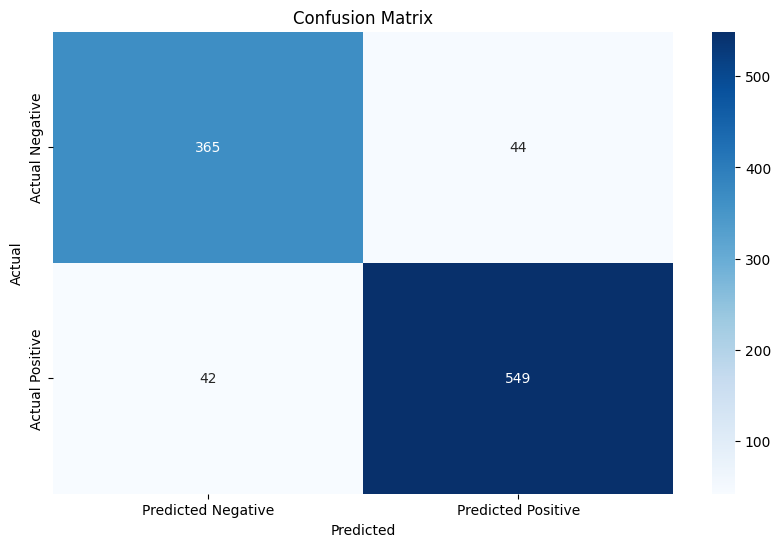

In [ ]:
# Calculate the confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)

# Create a DataFrame from the confusion matrix for better visualization
conf_mat_df = pd.DataFrame(conf_mat, columns=['Predicted Negative', 'Predicted Positive'], index=['Actual Negative', 'Actual Positive'])

# Create a new figure
plt.figure(figsize=(10,6))

# Use Seaborn's heatmap function to plot the confusion matrix
sns.heatmap(conf_mat_df, annot=True, fmt='d', cmap='Blues')

# Set the title and labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Display the plot
plt.show()

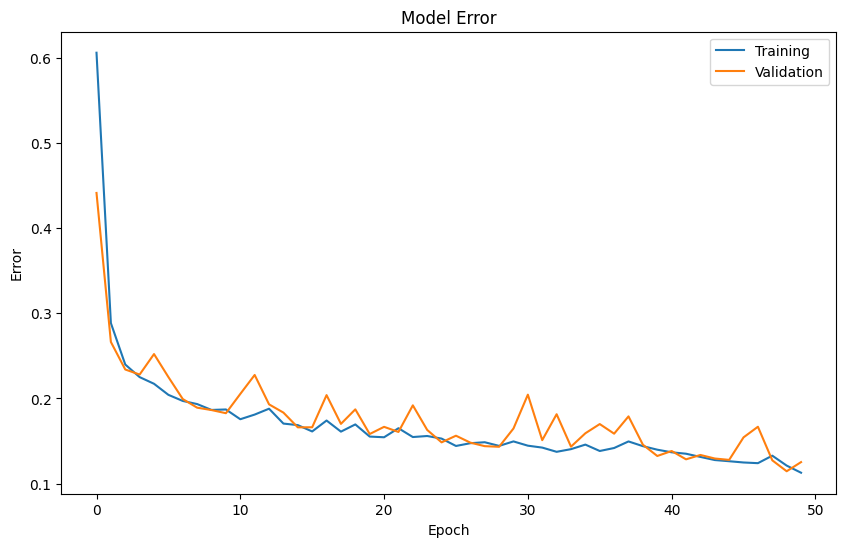

In [ ]:
import matplotlib.pyplot as plt

# Create a new figure
plt.figure(figsize=(10,6))

# Plot the training error
plt.plot(history.history['loss'], label='Training')

# Plot the validation error
plt.plot(history.history['val_loss'], label='Validation')

# Set the title and labels
plt.title('Model Error')
plt.xlabel('Epoch')
plt.ylabel('Error')

# Add a legend
plt.legend()

# Display the plot
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ls /content/gdrive/MyDrive/AbnormalECGClassifierModel

**Save Model to Drive**

In [ ]:
# Save the model using SavedModel format
saved_model_path = F"/content/gdrive/My Drive/AbnormalECGClassifierModel/ecgclassifier_cnn"
tf.saved_model.save(model, saved_model_path)

**Load Model from Drive**

In [ ]:
saved_model_path = F"/content/gdrive/My Drive/AbnormalECGClassifierModel/ecgclassifier_cnn"
loaded_model = tf.saved_model.load(saved_model_path)

In [ ]:
# Note loaded_model.predict() is not used for prediction
y_pred_0 = loaded_model(X_test_fe_0_reshaped)

print(f"y_pred_0 is {y_pred_0}")

y_pred_0 is [[0.85477924]]


**Convert Model into TFLite**

In [ ]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path) # path to the SavedModel directory

tflite_model = converter.convert()

saved_model_path_tflite = F"/content/gdrive/My Drive/AbnormalECGClassifierModel/ecgclassifier_cnn.tflite"

# Save the model.
with open(saved_model_path_tflite, 'wb') as f:
  f.write(tflite_model)

**Convert TFLite to C byte array**

In [ ]:
# Function: Convert some hex value into an array for C programming
def hex_to_c_array(hex_data, var_name):

  c_str = ''

  # Create header guard
  c_str += '#ifndef ' + var_name.upper() + '_H\n'
  c_str += '#define ' + var_name.upper() + '_H\n\n'

  # Add array length at top of file
  c_str += '\nunsigned int ' + var_name + '_len = ' + str(len(hex_data)) + ';\n'

  # Declare C variable
  c_str += 'unsigned char ' + var_name + '[] = {'
  hex_array = []
  for i, val in enumerate(hex_data) :

    # Construct string from hex
    hex_str = format(val, '#04x')

    # Add formatting so each line stays within 80 characters
    if (i + 1) < len(hex_data):
      hex_str += ','
    if (i + 1) % 12 == 0:
      hex_str += '\n '
    hex_array.append(hex_str)

  # Add closing brace
  c_str += '\n ' + format(' '.join(hex_array)) + '\n};\n\n'

  # Close out header guard
  c_str += '#endif //' + var_name.upper() + '_H'

  return c_str


In [ ]:
c_model_name = "ecgclassifier"
# Write TFLite model to a C source (or header) file
with open(c_model_name + '.h', 'w') as file:
  file.write(hex_to_c_array(tflite_model, c_model_name))

In [ ]:
# Testing the TFlite Model

# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="ecgclassifier_cnn.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print(input_details)
print(output_details)

# Test model on random input data.
input_shape = input_details[0]['shape']
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

[{'name': 'serving_default_conv1d_2_input:0', 'index': 0, 'shape': array([ 1, 19,  1], dtype=int32), 'shape_signature': array([-1, 19,  1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'StatefulPartitionedCall:0', 'index': 29, 'shape': array([1, 1], dtype=int32), 'shape_signature': array([-1,  1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[[0.536081]]
